In [1]:
import networkx as nx
import pickle

import numpy as np; np.set_printoptions(suppress=True, linewidth=180)
import pandas as pd; pd.set_option('display.width', 500)

#import os
#import ipywidgets as widgets
#from ipyfilechooser import FileChooser

from plot_module import plot_ode_results, plot_sde_results, plot_simulator_graph, plot_neuron_graph_subset
from sim_param_from_network import names_from_network, sde_param_from_network, ode_from_network, start_state_from_nodes
from neuron_graph_process import neuron_graph_process
from neuron_graph_helper import load_pickled_neuron_graph

from simulate import simulate_ode, simulate_gillespie, simulate_tauleaping

In [2]:
# # Specify the directory
# directory = 'neuron_shape_data'
# fc = FileChooser(directory)
# display(fc)
# file_path = fc.selected

In [12]:
#temp_fp = '/home/daniel/Projects/2023_Jones_Lab_mtDNA/SSD/SSD_Neuron/neuron_shape_data/m_hippocampus_NMO_97827.pkl'
#file_path = '/home/daniel/Projects/2023_Jones_Lab_mtDNA/SSD/SSD_Neuron/neuron_shape_data/h_cerebellum_interneuron_NMO_32551.pkl'
file_path = '/home/daniel/Projects/2023_Jones_Lab_mtDNA/SSD/SSD_Neuron/neuron_shape_data/m_hippocampus_NMO_97827.pkl'

In [13]:
imported_neuron_graph = load_pickled_neuron_graph(file_path)
# plot_neuron_graph_subset(imported_neuron_graph)

In [14]:
DELTA = 0.25
DEATH_RATE = 0.4
SWITCH_RATE_AR = 0.01
SWITCH_RATE_RA = 0.01
TRANSP_SPEED = 14000

SOMA_CB = 0.00001
SOMA_BR = 3.2
SOMA_NSS = 500
SOMA_DIFFUSION = 0.5
SOMA_MITO_DENSITY = 2 # number of mt/um^3 of volume

AXON_MITO_DENSITY = 2 # number of mt/um^3 of volume
AXON_TRNSP_ANT = 8
AXON_TRNSP_RET = 6

DENDRITE_MITO_DENSITY = 2 # number of mt/um^3 of volume

bio_param = {
    # global parameters    
    'delta': DELTA, 
    'switch_rate_ar': SWITCH_RATE_AR,
    'switch_rate_ra': SWITCH_RATE_RA,
    
    # soma parameters
    'soma_death_rate': DEATH_RATE, 
    'soma_mito_density': SOMA_MITO_DENSITY,
    'soma_cb': SOMA_CB, 
    'soma_br': SOMA_BR, 
    'soma_diffusion': SOMA_DIFFUSION,
    'soma_nss': None,
    
    # axon parameters
    'axon_death_rate': DEATH_RATE, 
    'axon_mito_density':AXON_MITO_DENSITY,
    'axon_nss': None,
    'axon_transp_speed': TRANSP_SPEED,
    'axon_terminal_influx': None,
    'axon_terminal_efflux': None,

    # dendrite paramters
    'dendrite_death_rate': DEATH_RATE, 
    'dendrite_mito_density': SOMA_MITO_DENSITY,
    'dendrite_nss': None,
    'dendrite_transp_speed': TRANSP_SPEED,
    'dendrite_terminal_influx': None,
    'dendrite_terminal_efflux': None,
    }


> Inferring target node populations per branch type from section volumes.
total soma volume is 278.06 µm^3 spread across 1 node(s). At a density of 2 mt/µm^3, this gives a target pop. of 556 mt/node
total axon volume is 4.36 µm^3 spread across 9 node(s). At a density of 2 mt/µm^3, this gives a target pop. of 1 mt/node
total dendrite volume is 3.95 µm^3 spread across 1 node(s). At a density of 2 mt/µm^3, this gives a target pop. of 8 mt/node

> Inferring net influx and efflux at at axon and dendrite terminals.
at a death rate of 0.4, a target axon pop. of 1, requires an influx of 0.8 mt and an outflow of 0.4 mt
at a death rate of 0.4, a target dendrite pop. of 8, requires an influx of 6.4 mt and an outflow of 3.2 mt

>> Transforming input graph:
> The undirected input graph has 11 nodes, and 10 edges. Found 2 branches:
axon of 9 nodes, total volume is 4.36 um^3
dendrite of 1 nodes, total volume is 3.95 um^3
> the directed output graph has 15 nodes, and 40 edges

>> Adding biological pa

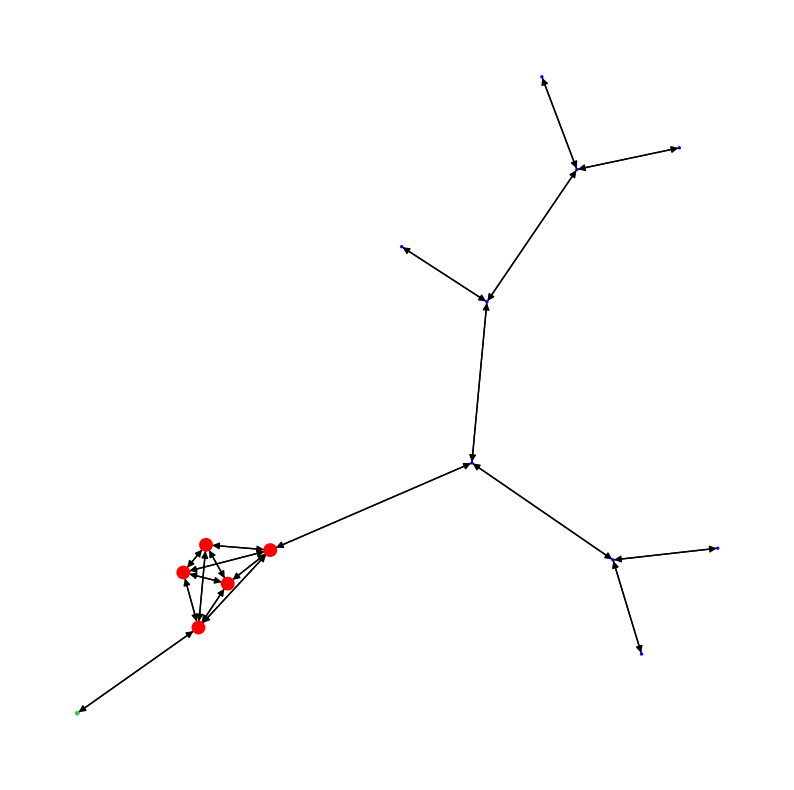


>>> Solving arbor subgraphs flows...

>> Solving subgraph 0

> Total outflow to this branch is 2.0216 mt/day

>> Solving subgraph 1

> Total outflow to this branch is 3.2 mt/day

<<< Finished solving >>>


> Adjusting soma birth rates to 0.409408 to match steady state demand from:
222.0 deaths (44.4/node), and 5.2216 net outflow (1/node) to the arbors.

>>> Solving within-soma flows...

<<< Finished solving >>>



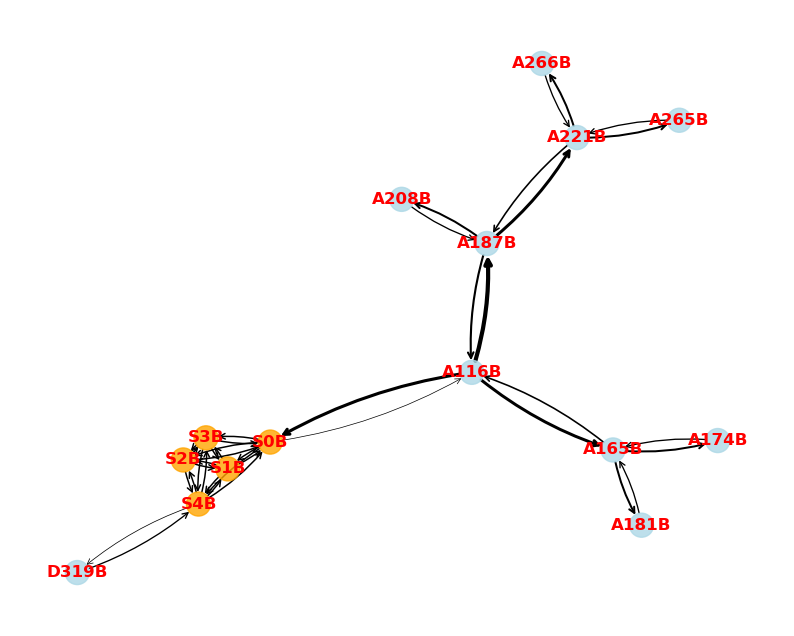

In [15]:
G = neuron_graph_process(
    input_graph = imported_neuron_graph,
    input_bio_param = bio_param,
    transform_type = 'bidirect',
    n_soma_nodes = 5,
    soma_g_type = 'complete',
    prnt = False,
    plot = True
)
plot_simulator_graph(G)

In [16]:
TIME_POINTS = np.linspace(0, 4000, 1001)
VARS, NODES = names_from_network(G)
START_STATE = start_state_from_nodes(G, heteroplasmy=0.5, delta=DELTA)

# infer the ode model
ode_model = ode_from_network(G, prnt=False)

# infer the parameterse of the sde systems
SDE_PARAM = sde_param_from_network(G, prnt=False)

# simulate system a bit, and allow to stabilize before running the full sims
START_STATE = simulate_ode(ode_model, np.linspace(0, 1000, 1001), START_STATE)[:,-1]

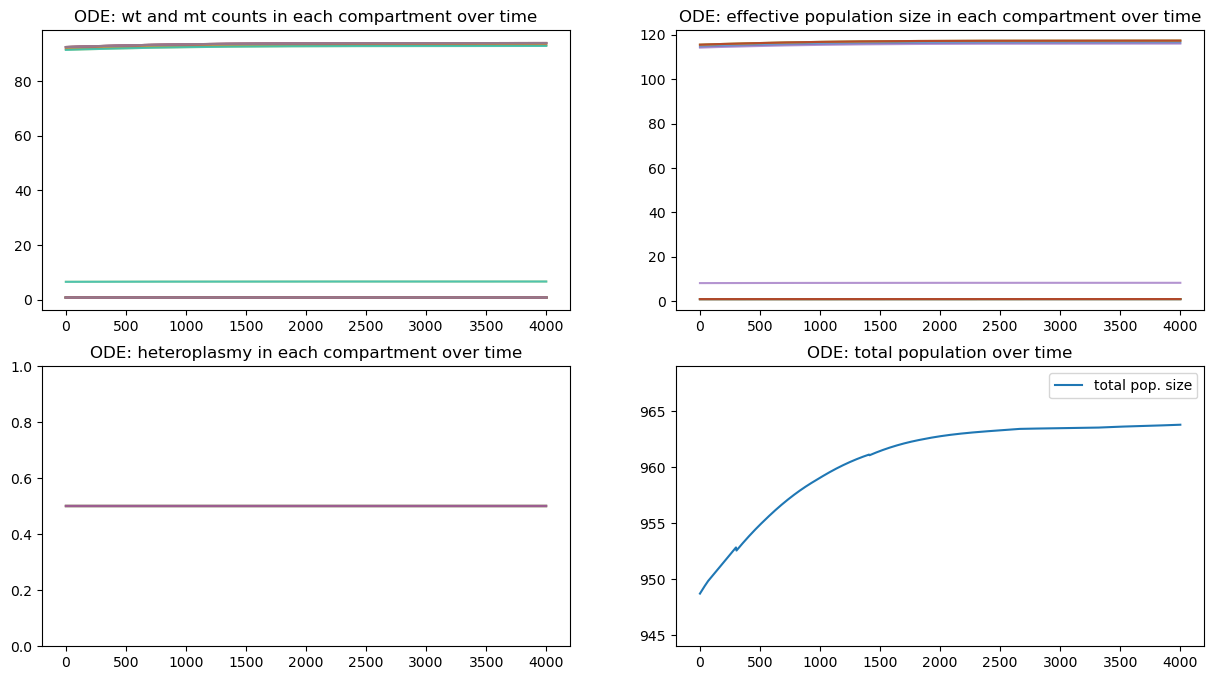

In [17]:
ode_results = simulate_ode(ode_model, TIME_POINTS, START_STATE)
plot_ode_results(ode_results, TIME_POINTS, DELTA, VARS, NODES, prnt=False)

simulating using gillespie...


100%|██████████| 100/100 [01:34<00:00,  1.06it/s]
/home/daniel/Projects/2023_Jones_Lab_mtDNA/SSD/SSD_Neuron/plot_module.py:138: RuntimeWarning: invalid value encountered in true_divide
  total_het = total_mt/(total_mt+total_wt)


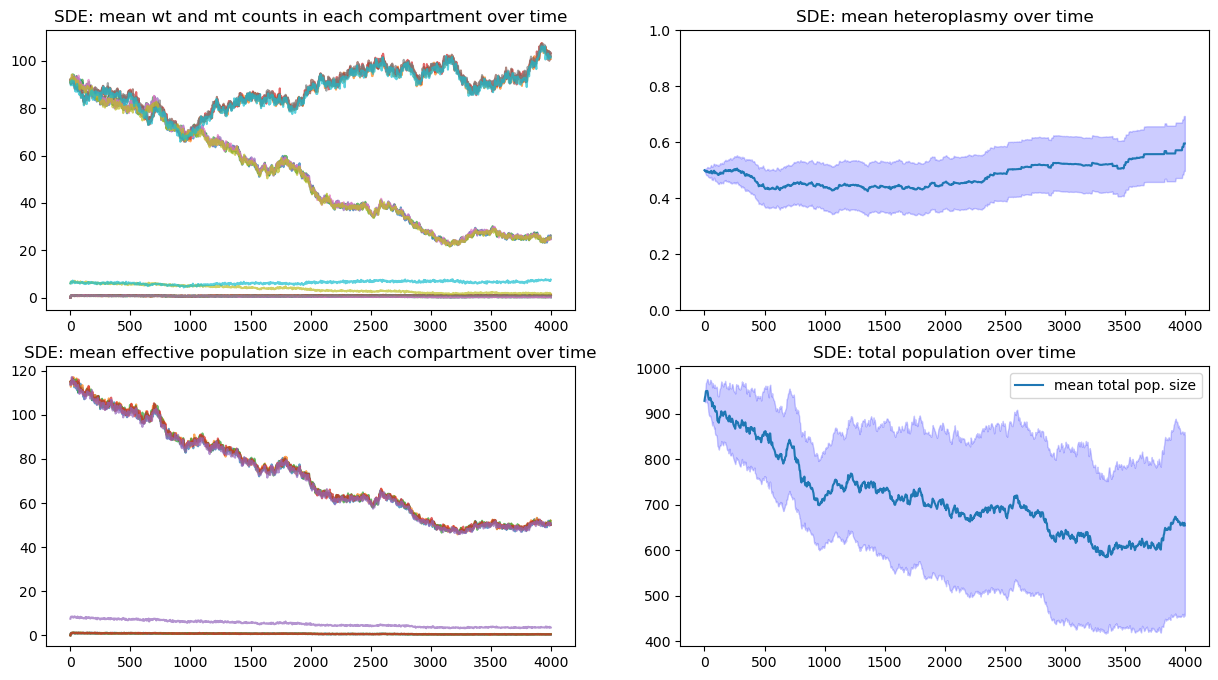


> Change in mean heteroplasmy: 
start: 0.5 +-0.0
final: 0.5957 +-0.0491
delta: 0.0957


In [18]:
gillespie_results = simulate_gillespie(SDE_PARAM, TIME_POINTS, START_STATE, replicates=100)
plot_sde_results(gillespie_results, TIME_POINTS, DELTA, VARS, NODES, prnt = False)

simulating using tau leaping...


100%|██████████| 100/100 [00:30<00:00,  3.32it/s]


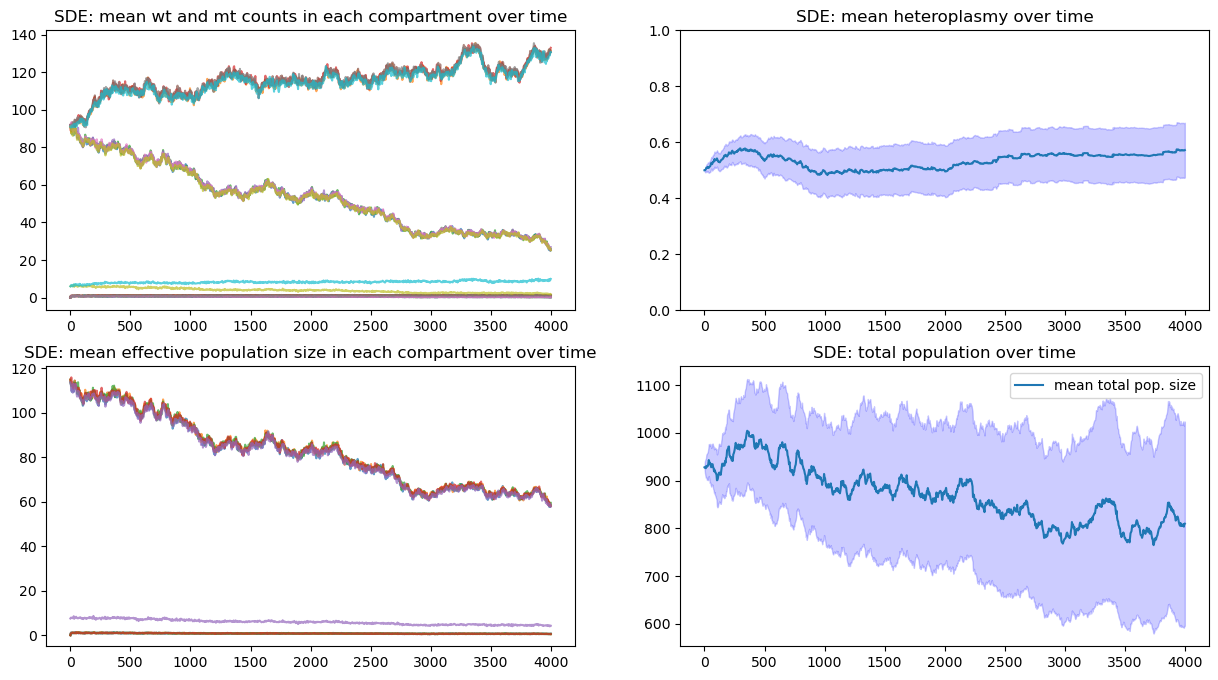


> Change in mean heteroplasmy: 
start: 0.5 +-0.0
final: 0.572 +-0.0489
delta: 0.072


In [19]:
tauleaping_results = simulate_tauleaping(SDE_PARAM, TIME_POINTS, START_STATE, replicates=100, timestep=0.01)
plot_sde_results(tauleaping_results, TIME_POINTS, DELTA, VARS, NODES, prnt = False)